In [1]:
from pathlib import Path

import earthkit.data
import earthkit.plots
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_zfp_classic import ZfpClassic
from numcodecs_wasm_sz3 import Sz3

In [2]:
wvpa = xr.open_dataset(
    Path() / "data" / "hoaps-c.r30.h06.wvpa.2020-08" / "data.nc",
    engine="netcdf4",
    decode_timedelta=True,
).wvpa.sel(time="2020-08-02")
wvpa

<xarray.DataArray 'wvpa' (time: 4, lat: 320, lon: 720)> Size: 4MB
[921600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 32B 2020-08-02 ... 2020-08-02T18:00:00
  * lat      (lat) float64 3kB 79.75 79.25 78.75 78.25 ... -78.75 -79.25 -79.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Attributes:
    long_name:       Water Vapor Path
    standard_name:   atmosphere_water_vapor_content
    units:           kg/m^2
    C_format:        %6.2f
    FORTRAN_format:  F6.2
    comment:         1D-Var: Algorithm Theoretical Baseline Document HOAPS ve...
    cell_methods:    area: mean
    code:            3

In [3]:
vmin, vmax = int(np.floor(np.amin(wvpa))), int(np.ceil(np.amax(wvpa)))
vmin, vmax

(2, 73)

In [4]:
zfp = ZfpClassic(mode="fixed-accuracy", tolerance=0.1)

encoded_zfp = zfp.encode(wvpa.values)
decoded_zfp = wvpa.copy(deep=True, data=zfp.decode(encoded_zfp))

In [5]:
zfp_sg = SafeguardsCodec(codec=zfp, safeguards=[dict(kind="abs", eb_abs=0.1, equal_nan=False)])

encoded_zfp_sg = zfp_sg.encode(wvpa.values)
decoded_zfp_sg = wvpa.copy(deep=True, data=zfp_sg.decode(encoded_zfp_sg, out=np.empty_like(wvpa.values)))

In [6]:
zfp_sg_nan = SafeguardsCodec(codec=zfp, safeguards=[dict(kind="abs", eb_abs=0.1, equal_nan=True)])

encoded_zfp_sg_nan = zfp_sg_nan.encode(wvpa.values)
decoded_zfp_sg_nan = wvpa.copy(deep=True, data=zfp_sg_nan.decode(encoded_zfp_sg_nan, out=np.empty_like(wvpa.values)))

In [7]:
sz3 = Sz3(eb_mode="abs", eb_abs=0.1)

encoded_sz3 = sz3.encode(wvpa.values)
decoded_sz3 = wvpa.copy(deep=True, data=sz3.decode(encoded_sz3))

In [8]:
sz3_sg = SafeguardsCodec(codec=sz3, safeguards=[dict(kind="abs", eb_abs=0.1, equal_nan=False)])

encoded_sz3_sg = sz3_sg.encode(wvpa.values)
decoded_sz3_sg = wvpa.copy(deep=True, data=sz3_sg.decode(encoded_sz3_sg, out=np.empty_like(wvpa.values)))

In [9]:
sz3_sg_nan = SafeguardsCodec(codec=sz3, safeguards=[dict(kind="abs", eb_abs=0.1, equal_nan=True)])

encoded_sz3_sg_nan = sz3_sg_nan.encode(wvpa.values)
decoded_sz3_sg_nan = wvpa.copy(deep=True, data=sz3_sg_nan.decode(encoded_sz3_sg_nan, out=np.empty_like(wvpa.values)))

In [10]:
sg = SafeguardsCodec(codec=None, safeguards=[dict(kind="abs", eb_abs=0.1, equal_nan=False)])

encoded_sg = sg.encode(wvpa.values)
decoded_sg = wvpa.copy(deep=True, data=sg.decode(encoded_sg, out=np.empty_like(wvpa.values)))

In [11]:
sg_nan = SafeguardsCodec(codec=None, safeguards=[dict(kind="abs", eb_abs=0.1, equal_nan=True)])

encoded_sg_nan = sg_nan.encode(wvpa.values)
decoded_sg_nan = wvpa.copy(deep=True, data=sg_nan.decode(encoded_sg_nan, out=np.empty_like(wvpa.values)))

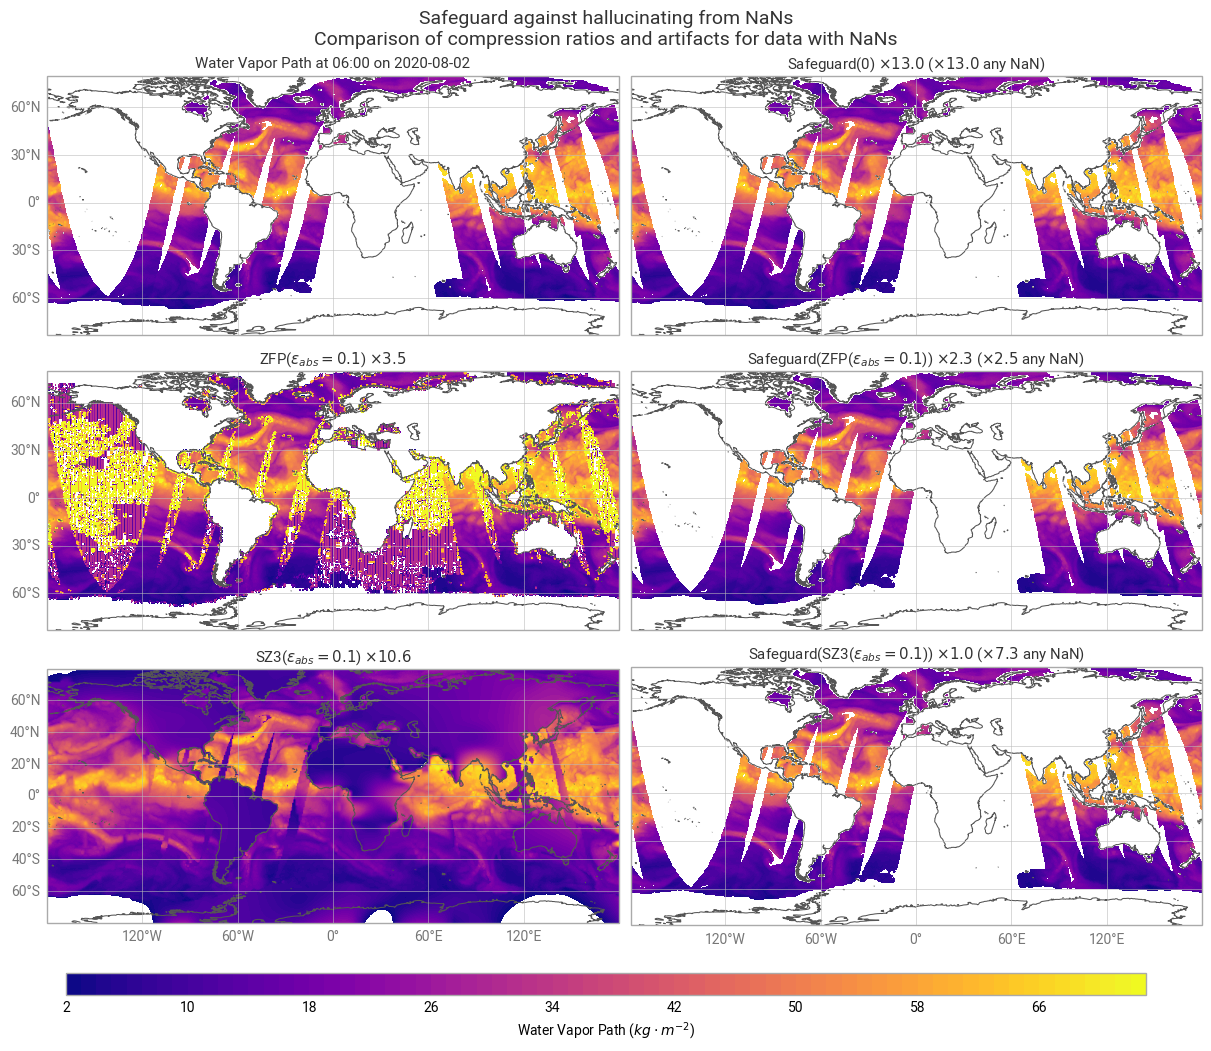

In [12]:
figure = earthkit.plots.Figure(
    size=(12, 9),
    rows=3,
    columns=2,
)

def quicksubplot(i, j, data, *args, **kwargs):
    subplot = figure.add_map(i, j)
    subplot.quickplot(
        earthkit.data.from_object(data),
        style=earthkit.plots.Style(levels=np.linspace(vmin, vmax, vmax-vmin+1)),
    )
    for m in earthkit.plots.schema.quickmap_subplot_workflow:
        getattr(subplot, m)()
    return subplot

quicksubplot(0, 0, wvpa.sel(time="2020-08-02T06:00"))
quicksubplot(1, 0, decoded_zfp.sel(time="2020-08-02T06:00")).title(
    rf"ZFP($\epsilon_{{{{abs}}}}=0.1$) $\times {round(wvpa.nbytes / encoded_zfp.nbytes, 1)}$"
)
quicksubplot(2, 0, decoded_sz3.sel(time="2020-08-02T06:00")).title(
    rf"SZ3($\epsilon_{{{{abs}}}}=0.1$) $\times {round(wvpa.nbytes / encoded_sz3.nbytes, 1)}$"
)

quicksubplot(0, 1, decoded_sg.sel(time="2020-08-02T06:00")).title(
    rf"Safeguard(0) $\times {round(wvpa.nbytes / np.array(encoded_sg).nbytes, 1)}$ "
    rf"($\times {round(wvpa.nbytes / np.array(encoded_sg_nan).nbytes, 1)}$ any NaN)"
)
quicksubplot(1, 1, decoded_zfp_sg.sel(time="2020-08-02T06:00")).title(
    rf"Safeguard(ZFP($\epsilon_{{{{abs}}}}=0.1$)) $\times {round(wvpa.nbytes / np.array(encoded_zfp_sg).nbytes, 1)}$ "
    rf"($\times {round(wvpa.nbytes / np.array(encoded_zfp_sg_nan).nbytes, 1)}$ any NaN)"
)
quicksubplot(2, 1, decoded_sz3_sg.sel(time="2020-08-02T06:00")).title(
    rf"Safeguard(SZ3($\epsilon_{{{{abs}}}}=0.1$)) $\times {round(wvpa.nbytes / np.array(encoded_sz3_sg).nbytes, 1)}$ "
    rf"($\times {round(wvpa.nbytes / np.array(encoded_sz3_sg_nan).nbytes, 1)}$ any NaN)"
)

for m in earthkit.plots.schema.quickmap_figure_workflow:
    if m != "legend":
        getattr(figure, m)()

ax = plt.axes((0.05, -0.05, 0.9, 0.025))
figure.legend(ax=ax)

figure.title("Safeguard against hallucinating from NaNs\nComparison of compression ratios and artifacts for data with NaNs")
figure.show()